# ML Model Implementation

- Given the offer features and user demographics, we will develop three alternative models to predict the effectiveness of an offer for each offer type. 

- Then, we build an all-in-one model to see if we can predict the effectiveness of an offer by including the offer type as a categorical variable. Would the nature of the offer influence the user's responsiveness? 

- Finally, we will attempt to develop a regression model to predict how much someone would spend in response to a successful offer.

## Datasets

The data is contained in three files:

* portfolio.json - containing offer ids and other attributes about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

## Table of Contents

* [Load Data](#heading1)
* [Data Preprocessing](#heading2)
* [Model Building](#heading3)
    1. [ML models for all offer types](#heading3.1)
    2. [All in one ML model](#heading3.2)    
    3. [Predict transaction amount](#heading3.3)    

Import all necessary libraries

In [1]:
import pandas as pd
import json
import numpy as np
import pickle
import time
import joblib

In [2]:
# importing sys
import sys
# adding scripts to the system path
sys.path.insert(0, '/Users/fidahussainrao/Downloads/Predict customer response/scripts')

In [3]:
from train import *

import matplotlib.pyplot as plt
import plotly.io as pio
pio.renderers.default='notebook'

#data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# ml models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

import warnings
warnings.filterwarnings('ignore')

## Load Data<a class="anchor" id="heading1"></a>

In [4]:
profile = pd.read_csv('../data/cleaned/profile.csv')
portfolio = pd.read_csv('../data/cleaned/portfolio.csv')
transcript_processed = pd.read_csv('../data/cleaned/transcript_processed.csv')
df = pd.read_csv('../data/cleaned/feat_engineered.csv')

In [5]:
df.head()

,offer_success,offer_id,person_id,percent_success,total_similar_offers_received,total_offers_received
0,0,ae264e3637204a6fb9bb56bc8210ddfd,b84430e82831484aaa3642e41ada16d0,0.460455,1,5
1,1,5a8bc65990b245e5a138643cd4eb9837,b84430e82831484aaa3642e41ada16d0,0.543564,1,5
2,0,4d5c57ea9a6940dd891ad53e9dbe8da0,b84430e82831484aaa3642e41ada16d0,0.445979,1,5
3,1,ae264e3637204a6fb9bb56bc8210ddfd,21c16cf0c293423ca08647079f1783c7,0.460455,1,5
4,1,2906b810c7d4411798c6938adc9daaa5,21c16cf0c293423ca08647079f1783c7,0.487163,1,5


## Data Preprocessing<a class="anchor" id="heading2"></a>


Create dummy variables of the following columns:
   
   * Offer type 
   * Gender
   * Membership year
   
A Machine learning model would not be able to comprehend string variables, hence it is imperative to convert the string values to integer. This can be achieved by creating dummy variables of those columns. A dummy variable will create a column for every unique value in each column and will return values of 0 and 1, where the values indicate the presence or absence of something.

In [6]:
portfolio = pd.get_dummies(portfolio, columns=['offer_type'])

In [7]:
profile = pd.get_dummies(profile, columns=['gender', 'membership_year'])

Now, I'll be eliminating irrelevant columns. If we keep irrelevant columns in our data, our model will take an unnecessary amount of time. These columns include:
   * membership_month - new memberships are constant throughout the year, hence it does not add any value.
   * membership_day - this value also won't add any value to our analysis.
   * age_group - age column is already present in the dataset, hence this is a duplicate column.

In [8]:
profile = profile.drop(['membership_month', 'membership_day'],axis=1)

Finally, merge the preprocessed profile and portfolio datasets with the offer success and number of offers recieved columns from the previous section. 

In [9]:
df = pd.merge(df, portfolio.iloc[:,1:], on='offer_id', how='inner')
df = pd.merge(df, profile, on='person_id', how='inner')
df.head()

,offer_success,offer_id,person_id,percent_success,total_similar_offers_received,total_offers_received,duration,difficulty,reward,email,...,member_since,gender_F,gender_M,gender_O,membership_year_2013,membership_year_2014,membership_year_2015,membership_year_2016,membership_year_2017,membership_year_2018
0,0,ae264e3637204a6fb9bb56bc8210ddfd,b84430e82831484aaa3642e41ada16d0,0.460455,1,5,7,10,10,1,...,1849,1,0,0,0,0,0,0,1,0
1,1,5a8bc65990b245e5a138643cd4eb9837,b84430e82831484aaa3642e41ada16d0,0.543564,1,5,3,0,0,1,...,1849,1,0,0,0,0,0,0,1,0
2,0,4d5c57ea9a6940dd891ad53e9dbe8da0,b84430e82831484aaa3642e41ada16d0,0.445979,1,5,5,10,10,1,...,1849,1,0,0,0,0,0,0,1,0
3,1,ae264e3637204a6fb9bb56bc8210ddfd,21c16cf0c293423ca08647079f1783c7,0.460455,1,5,7,10,10,1,...,2455,0,1,0,0,0,1,0,0,0
4,1,2906b810c7d4411798c6938adc9daaa5,21c16cf0c293423ca08647079f1783c7,0.487163,1,5,7,10,2,1,...,2455,0,1,0,0,0,1,0,0,0


In [10]:
## checking the distribution of values in offer success column
df['offer_success'].value_counts()

1    21269
0    18486
Name: offer_success, dtype: int64

It can be observed that the dataset is slightly skewed. There are more successful offers than non successful ones. However, the difference is so minimal that the resampling of dataset is not really required.

We will be removing the unique ID columns, since they are independent. Plus, they don't somehow identify the target class

In [11]:
# dropping unique columns
df.drop(['person_id', 'offer_id'],axis=1,inplace=True)

In [12]:
def preprocess(data, target_class='offer_success', test_size=0.25):
    
    """ 
    Split the given dataset into train and test datasets. Then normalize
    them to convert different variables belonging to various units into 
    the same scale. 
    INPUT:
        data: merged dataframe containing customer profile, 
              offer portfolio, offer success
        target_class: name of the dependent variable.
        test_size: ratio of test data to train data
    
    OUTPUT:    
        X_train: normalized features for training the model.
        y_train: target variables for training the model.
        X_test: normalized features for testing the model
        y_test: target variables for testing the model
    """
    # defining the independent (X) and dependent (y) variables.
    X = data.drop(target_class,axis=1)
    y = data[target_class]
    
    # train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    # min max scaler to bring all the columns in the same range of 0 - 1.
    scale = MinMaxScaler()
    X_train = scale.fit_transform(X_train)
    X_test = scale.transform(X_test)
    
    return X_train, y_train, X_test, y_test

In [13]:
X_train, y_train, X_test, y_test = preprocess(df)

## Model Building<a class="anchor" id="heading3"></a>

Following the pre-processing of the data, we will begin to develop models to determine which features most influence whether the customer will respond to the offer or not. 

As a result, we'll utilise the dataset's 'offer success' column to train models that predict whether or not the customer will accept the offer. In this section, we will take the basic tree model as a starting point to better explain feature importance and obtain insight into which features have the biggest influence on consumer behaviour. Meanwhile, in order to obtain high accuracy in training the model, I'll compare the baseline model to random forest and gradient boost as alternate models.

In [14]:
offer_type_cols = ['offer_type_discount', 'offer_type_bogo', 'offer_type_informational']

In [15]:
def divide_offer_types(data, offer_type):
    '''
    Extracts the data for the given offer type.
    INPUT:
        data: combined dataframe, containing data 
        for all offer types.
        offer_type: one of the three offer types.
    
    OUTPUT:
        data: combined dataframe, containing data 
        for only the given offer type.
        X_train: normalized training feats for given offer type.
        y_train: train target variables for given offer type.
        X_test: normalized testing feats for given offer type.
        y_test: train target variables for given offer type.
    '''
    
    if offer_type == 'discount':
        var = 0
    elif offer_type == 'bogo':
        var = 1
    else:
        var = 2
    data = data[data[offer_type_cols[var]]==1].drop(offer_type_cols, axis=1)
    print(data['offer_success'].value_counts())
    
    X_train, y_train, X_test, y_test = preprocess(data)
    
    return data, X_train, y_train, X_test, y_test

In [16]:
def plot_imp_feats(feat_imp):
   '''
   Get a historical bar chart with the x-axis representing feature 
   importance in predicting the target variable and the y-axis 
   representing feature name.
    INPUT:
        feat_imp: dataframe containing feature name and its importance.
    '''
    plt.figure(figsize=(12,6))
    plt.barh(width= feat_imp['importance'], y=feat_imp.index, color='lightblue')
    plt.title('Feature Importance')
    plt.ylabel('Feature')
    plt.show()
    

def get_imp_feats(model, data, imp_score = 0.0075):
    
    '''
    Reduce the size of the train and test data by removing unnecessary
    columns.
    INPUT:
        model: fitted ensemble model
        data: combined and preprocessed dataframe.
        imp_score: threshold feature importance
    OUTPUT:
        X_train: reduced training data after feature selection.
        y_train: reduced target classes for training.
        X_test: reduced testing data after feature selection.
        y_test: reduced target classes for testing.
    '''
    
    feat_imp = pd.DataFrame(dict(zip(data.columns[1:], model.feature_importances_)), index=range(1)).T
    feat_imp.columns = ['importance']
    feat_imp = feat_imp.sort_values(by='importance',ascending=False)

    plot_imp_feats(feat_imp)
    
    imp_cols = list(feat_imp[feat_imp['importance'] >= imp_score].index)
    data = data[imp_cols+['offer_success']]
    X_train, y_train, X_test, y_test = preprocess(data)
    
    return X_train, y_train, X_test, y_test

I've defined the functions to run my model in a seperate `.py` file since I intend to implement three separate models, making it easy to do so frequently. `Metrics` defined in the function to evaluate the models are: F1 score, accuracy, and auc score.
    
   * Accuracy is effective if the classes are balanced. 
   * F1 score is effective if the negative class is dominant. 
   * If the positive class is in the majority, the auc score will be effective.

### a. Predicting Customer Response to an Offer<a class="anchor" id="heading3.1"></a>
We will begin by creating `three` seperate classification models for each offer type, depending on offer portfolio and user demographic.

#### Discount Offer Type

First we try to build the discount offer models. I initialize by building a baseline tree model and compare that performance with alternative models such as Random Forest and Gradient Boosting. These models will be initialized by using default parameters. If performance needs to be improved further, I will attempt Grid Search to find the optimal parameters.

In [17]:
df1, X_train1, y_train1, X_test1, y_test1 = divide_offer_types(df, 'discount')

1    8814
0    6245
Name: offer_success, dtype: int64


In [18]:
# since there are slightly more positive classes, we will be comparing auc scores of different models

#### <i> Baseline model (Decision tree) </i>

In [18]:
dc = DecisionTreeClassifier()
scores_ai = train(dc, X_train1, y_train1, X_test1, y_test1)

DecisionTreeClassifier took 0.06 seconds to train on the data.

Accuracy: 0.6728
AUC score: 0.6627
F1 score: 0.7203

              precision    recall  f1-score   support

           0       0.61      0.60      0.61      1575
           1       0.72      0.72      0.72      2190

    accuracy                           0.67      3765
   macro avg       0.66      0.66      0.66      3765
weighted avg       0.67      0.67      0.67      3765



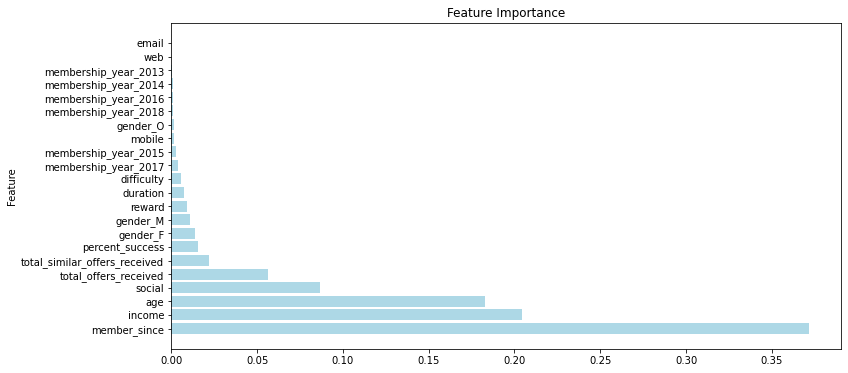

In [19]:
X_train11, y_train11, X_test11, y_test11 = get_imp_feats(dc, df1)

Top **three** features for predicting offer success, given `discount` offer type: 
   - tenure of members
   - income of the member
   - age of the member

#### <i> Alternate Models </i>

In [20]:
perf = {}
perf['offer_type'], perf['name'], perf['acc'], perf['auc'], perf['f1'] = [], [], [], [], []

In [21]:
clf_a1 = RandomForestClassifier(random_state=0)
clf_a2 = GradientBoostingClassifier(random_state=0)
models_a = [clf_a1, clf_a2]
for clf in models_a:
    scores_a = train(clf, X_train11, y_train11, X_test11, y_test11)
    perf['offer_type'].append('discount')
    perf['name'].append(clf.__class__.__name__)
    perf['acc'].append(scores_a[0])
    perf['auc'].append(scores_a[1])    
    perf['f1'].append(scores_a[2])   


RandomForestClassifier took 1.04 seconds to train on the data.

Accuracy: 0.7363
AUC score: 0.8141
F1 score: 0.7721

              precision    recall  f1-score   support

           0       0.68      0.69      0.69      1575
           1       0.78      0.77      0.77      2190

    accuracy                           0.74      3765
   macro avg       0.73      0.73      0.73      3765
weighted avg       0.74      0.74      0.74      3765

GradientBoostingClassifier took 1.15 seconds to train on the data.

Accuracy: 0.7543
AUC score: 0.8356
F1 score: 0.7867

              precision    recall  f1-score   support

           0       0.70      0.72      0.71      1575
           1       0.79      0.78      0.79      2190

    accuracy                           0.75      3765
   macro avg       0.75      0.75      0.75      3765
weighted avg       0.76      0.75      0.75      3765



In terms of the AUC score, both models are above 80%, with the Gradient boosting model performing slightly better compared to the Random Forest model, with **83.56%** vs **81.41%**.


#### BOGO Offer Type

Now we will build the bogo offer models. I will repeat the same steps as above.

In [22]:
df2, X_train2, y_train2, X_test2, y_test2 = divide_offer_types(df, 'bogo')


1    8574
0    8546
Name: offer_success, dtype: int64


In [ ]:
# it appears that the dataset is almost balanced; hence,we will be comparing accuracy

#### <i> Baseline model (Decision tree) </i>

In [23]:
dc = DecisionTreeClassifier()
scores_aii = train(dc, X_train2, y_train2, X_test2, y_test2)

DecisionTreeClassifier took 0.07 seconds to train on the data.

Accuracy: 0.6329
AUC score: 0.6332
F1 score: 0.6320

              precision    recall  f1-score   support

           0       0.62      0.65      0.63      2101
           1       0.65      0.62      0.63      2179

    accuracy                           0.63      4280
   macro avg       0.63      0.63      0.63      4280
weighted avg       0.63      0.63      0.63      4280



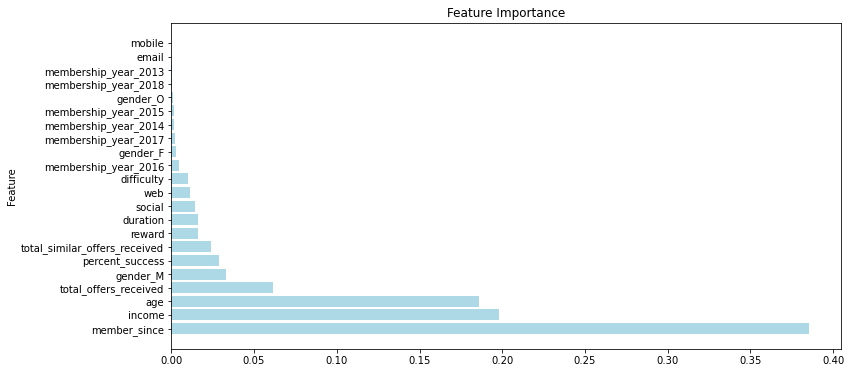

In [24]:
X_train21, y_train21, X_test21, y_test21 = get_imp_feats(dc, df2)

Top **three** features for predicting offer success, given `bogo` offer type: 
   - tenure of members
   - income of the member
   - age of the member

#### <i> Alternate Models </i>

In [25]:
clf_b1 = RandomForestClassifier(random_state=0)
clf_b2 = GradientBoostingClassifier(random_state=0)
models_b = [clf_b1, clf_b2]
for clf in models_b:
    scores_b = train(clf, X_train21, y_train21, X_test21, y_test21)
    perf['offer_type'].append('bogo')
    perf['name'].append(clf.__class__.__name__)
    perf['acc'].append(scores_b[0])
    perf['auc'].append(scores_b[1])    
    perf['f1'].append(scores_b[2])   

RandomForestClassifier took 1.18 seconds to train on the data.

Accuracy: 0.6843
AUC score: 0.7496
F1 score: 0.6820

              precision    recall  f1-score   support

           0       0.67      0.70      0.69      2101
           1       0.70      0.66      0.68      2179

    accuracy                           0.68      4280
   macro avg       0.68      0.68      0.68      4280
weighted avg       0.69      0.68      0.68      4280

GradientBoostingClassifier took 1.3 seconds to train on the data.

Accuracy: 0.7152
AUC score: 0.7795
F1 score: 0.7135

              precision    recall  f1-score   support

           0       0.70      0.73      0.72      2101
           1       0.73      0.70      0.71      2179

    accuracy                           0.72      4280
   macro avg       0.72      0.72      0.72      4280
weighted avg       0.72      0.72      0.72      4280



In terms of the accuracy, both models are below 75%, with the Gradient boosting model performing slightly better compared to the Random Forest model, with **71.52%** vs **68.43%**.

#### Informational Offer type

Now we will build the informational offer models. I will repeat the same steps as above.

In [26]:
df3, X_train3, y_train3, X_test3, y_test3 = divide_offer_types(df, 'informational')

1    3881
0    3695
Name: offer_success, dtype: int64


In [ ]:
# it appears that the dataset is almost balanced; hence,we will be comparing accuracy.

#### <i> Baseline model (Decision tree) </i>

In [27]:
dc = DecisionTreeClassifier()
scores_aiii = train(dc, X_train3, y_train3, X_test3, y_test3)

DecisionTreeClassifier took 0.03 seconds to train on the data.

Accuracy: 0.5380
AUC score: 0.5376
F1 score: 0.5524

              precision    recall  f1-score   support

           0       0.53      0.52      0.52       925
           1       0.55      0.56      0.55       969

    accuracy                           0.54      1894
   macro avg       0.54      0.54      0.54      1894
weighted avg       0.54      0.54      0.54      1894



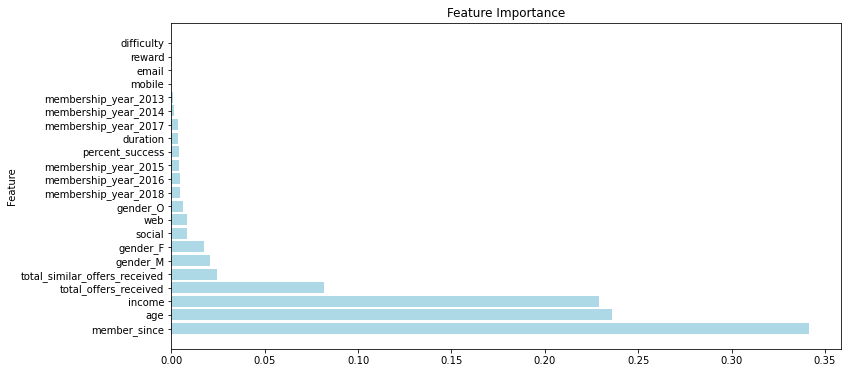

In [28]:
X_train31, y_train31, X_test31, y_test31 = get_imp_feats(dc, df3)

Top **three** features for predicting offer success, given `bogo` offer type: 
   - tenure of member
   - age of the member
   - income of the member

#### <i> Alternate Models </i>

In [29]:
clf_c1 = RandomForestClassifier(random_state=0)
clf_c2 = GradientBoostingClassifier(random_state=0)
models_c = [clf_c1, clf_c2]
for clf in models_c:
    scores_c = train(clf, X_train31, y_train31, X_test31, y_test31)
    perf['offer_type'].append('informational')
    perf['name'].append(clf.__class__.__name__)
    perf['acc'].append(scores_c[0])
    perf['auc'].append(scores_c[1])    
    perf['f1'].append(scores_c[2]) 

RandomForestClassifier took 0.62 seconds to train on the data.

Accuracy: 0.6014
AUC score: 0.6380
F1 score: 0.6185

              precision    recall  f1-score   support

           0       0.60      0.57      0.58       925
           1       0.61      0.63      0.62       969

    accuracy                           0.60      1894
   macro avg       0.60      0.60      0.60      1894
weighted avg       0.60      0.60      0.60      1894

GradientBoostingClassifier took 0.54 seconds to train on the data.

Accuracy: 0.6188
AUC score: 0.6647
F1 score: 0.6515

              precision    recall  f1-score   support

           0       0.63      0.54      0.58       925
           1       0.61      0.70      0.65       969

    accuracy                           0.62      1894
   macro avg       0.62      0.62      0.62      1894
weighted avg       0.62      0.62      0.62      1894



In terms of the accuracy, both models are below 65%, with the Gradient boosting model performing slightly better compared to the Random Forest model, with **61.88%** vs **60.14%**.

### b. Using Offer Type as a Categorical Feature to Predict Customer Response<a class="anchor" id="heading3.2"></a>

In [30]:
df['offer_success'].value_counts()

1    21269
0    18486
Name: offer_success, dtype: int64

#### <i> Baseline model (Decision tree) </i>

In [31]:
dc = DecisionTreeClassifier()
scores_b = train(dc, X_train, y_train, X_test, y_test)

DecisionTreeClassifier took 0.18 seconds to train on the data.

Accuracy: 0.6341
AUC score: 0.6318
F1 score: 0.6614

              precision    recall  f1-score   support

           0       0.60      0.60      0.60      4551
           1       0.66      0.66      0.66      5388

    accuracy                           0.63      9939
   macro avg       0.63      0.63      0.63      9939
weighted avg       0.63      0.63      0.63      9939



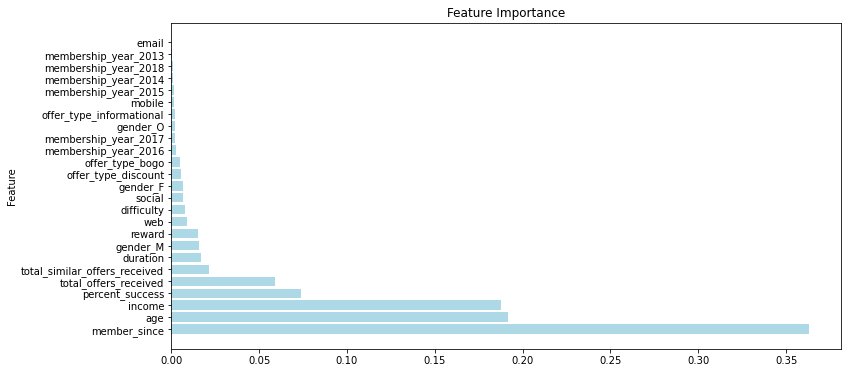

In [32]:
X_train, y_train, X_test, y_test = get_imp_feats(dc, df)

#### <i> Alternate Models </i>

In [33]:
clf_d1 = RandomForestClassifier(random_state=0)
clf_d2 = GradientBoostingClassifier(random_state=0)
models_d = [clf_d1, clf_d2]
for clf in models_d:
    scores_d = train(clf, X_train, y_train, X_test, y_test)
    perf['offer_type'].append('All')
    perf['name'].append(clf.__class__.__name__)
    perf['acc'].append(scores_d[0])
    perf['auc'].append(scores_d[1])    
    perf['f1'].append(scores_d[2]) 

RandomForestClassifier took 3.06 seconds to train on the data.

Accuracy: 0.6933
AUC score: 0.7644
F1 score: 0.7147

              precision    recall  f1-score   support

           0       0.66      0.68      0.67      4551
           1       0.72      0.71      0.71      5388

    accuracy                           0.69      9939
   macro avg       0.69      0.69      0.69      9939
weighted avg       0.69      0.69      0.69      9939

GradientBoostingClassifier took 3.12 seconds to train on the data.

Accuracy: 0.7124
AUC score: 0.7886
F1 score: 0.7311

              precision    recall  f1-score   support

           0       0.68      0.70      0.69      4551
           1       0.74      0.72      0.73      5388

    accuracy                           0.71      9939
   macro avg       0.71      0.71      0.71      9939
weighted avg       0.71      0.71      0.71      9939



#### <i>  GridSearch </i> 

To increase the model's performance, we will now attempt to tweak the parameters of the RF and GB models using the GridSearch approach.



In [34]:
fitted_models, scores = grid_pipeline(X_train, y_train, X_test, y_test, 'roc_auc')

Started training for rfc model
Successfully fitted rfc model
Started training for gbc model
Successfully fitted gbc model


In [35]:
print('Performance of all the fitted models on the discount offer type.')
for idx, key in enumerate(fitted_models.keys()):
    print(key, ':', scores[idx])
    print('-------------------------------------')

Performance of all the fitted models on the discount offer type.
rfc : 0.78782739363841
-------------------------------------
gbc : 0.7909352872346517
-------------------------------------


In [36]:
fitted_models['gbc'].best_params_

{'gradientboostingclassifier__learning_rate': 0.1,
 'gradientboostingclassifier__min_samples_leaf': 1,
 'gradientboostingclassifier__n_estimators': 200}

The AUC for the RF model increased significantly from 76.44% to 78.78%, while the AUC of GB model increased from 78.86% to 79.09%. There is a minimal increase in performance for GB model, which indicates that perhaps there's not much that can be done to improve the performance of the model with parameter tuning.

Comparing the performance of the 3 best models for each offer type with the all_in_one model, we can see that the all_in_one model is not as good as the GB bogo and RF discount models, and is significantly better than the GB informational model. This is probably due to informational offer type bringing down the performance of all_in_one model. Hence, I think that keeping 3 separate models is not very useful.

In [38]:
# save the best model
joblib.dump(fitted_models['gbc'], "../model/all_in_one_model.pkl") 

['../model/all_in_one_model.pkl']

### c. Predicting How Much a Customer Would Spend Given a Successful Offer.<a class="anchor" id="heading3.3"></a>
Finally, given a successful order, I will attempt to develop a regression model to estimate how much a consumer will spend. We will be using offer type as a categorical feature. 
To accomplish this, we will extract the effective offers and then sum the amount spent on an indivisual offer by each consumer.

In [39]:
with open('../data/cleaned/offer_success.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

In [40]:
effective_ids = pd.DataFrame.from_dict(loaded_dict)
# get only the successful offers
effective_ids = effective_ids[effective_ids['offer_success'] == 1]
# getting the order ids and person ids, this will be used to get the total amount spent.
effective_ids = effective_ids[['offer_id', 'person_id']]


In [41]:
# merge with the transcript data.
# This will be further used to sum up the transactions for each customer for an offer.
amount_data = pd.merge(transcript_processed, effective_ids, on=['person_id', 'offer_id'], how='inner')
amount_data = amount_data.groupby(['person_id', 'offer_id']).sum()['amount'].reset_index()
amount_data.head(3)

,person_id,offer_id,amount
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,22.16
1,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,11.93
2,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,45.08


Merge the amount spend by all the customers for each offer with the user demographics and order portfolio dataframes.

In [42]:
amount_data = pd.merge(portfolio.iloc[:,1:], amount_data, on='offer_id', how='inner')
amount_data = pd.merge(profile, amount_data, on='person_id', how='inner')
amount_data.head(3)

,age,person_id,income,member_since,gender_F,gender_M,gender_O,membership_year_2013,membership_year_2014,membership_year_2015,...,difficulty,reward,email,web,mobile,social,offer_type_bogo,offer_type_discount,offer_type_informational,amount
0,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1894,1,0,0,0,0,0,...,5,5,1,1,1,0,1,0,0,37.67
1,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1894,1,0,0,0,0,0,...,0,0,1,0,1,1,0,0,1,19.67
2,68,e2127556f4f64592b11af22de27a7932,70000.0,1542,0,1,0,0,0,0,...,10,2,1,1,1,1,0,1,0,18.42


Since this is a regression model, we need to prevent multicollinearity by reducing the level of the dummy variables by 1, dropping those columns.

In [43]:
amount_data.drop(['gender_O', 'membership_year_2013', 'social', 'offer_type_informational'], 
                 axis=1, inplace=True)

## removing unique ids as well.
amount_data.drop(['person_id', 'offer_id'], axis=1, inplace=True)

In [44]:
# 1. split the dataframe into train and test dataset
# 2. Scale the features to a range of 0 and 1.
X_train, y_train, X_test, y_test = preprocess(amount_data, target_class='amount')

In [45]:
reg_1 = Ridge(alpha=100,random_state=2)
reg_2 = RandomForestRegressor(random_state=0)
regressors = [reg_1, reg_2]
for reg in regressors:
    sc_reg = train(reg, X_train, y_train, X_test, y_test, classifier=False)

Ridge took 0.02 seconds to train on the data.

r2 score: 0.0672
Mean Squared Error: 2808.9303
Root Mean Squared Error: 52.9993

RandomForestRegressor took 5.97 seconds to train on the data.

r2 score: -0.0595
Mean Squared Error: 3190.6987
Root Mean Squared Error: 56.4863



In terms of predicting the amount spent, the regression model significantly underperformed. It looks that there is insufficient information to predict the amount based on the data for customers who successfully finished their offer.

## Conclusion

From the result of the project, it is possible to utilise a machine learning model to predict whether or not the customer will complete the offer. 

Goal of this project was to determine the following questions: 

1. What features primarily influence customer use of the offer? 

The feature importance assigned by three models indicates that the term of the membership is the most critical element influencing how customers respond to the offer. 
The top three variables for all three models were nearly identical for each offer type: `length of membership`, `income`, and `age`. However, the order of income and age changed based on the type of offer. 

2. Given the data available, including the offer attributes and user demographics, indicate whether a user would accept an offer? 

I've decided to use a single model with offer type as a categorical variable to predict whether or not the consumer will respond to the offer, with 'offer success' as a target variable. This model achieved an AUC score of `around 78 percent`. I also created three separate models for each offer type, with the models for the bogo and discount offer types performing well. Despite the fact that the model performance of the informational offer was significantly worse, it is still acceptable in this stage of research.